In [1]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy import stats

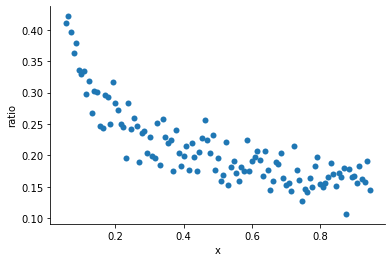

In [9]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/Extensions_MKT/'
file_name = 'sample_polymorphism_levels.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t') 
df['ratio'] = df['pN'] / df['pS']

# sns.scatterplot(data=df, x='x', y='pN', linewidth=0)
# sns.scatterplot(data=df, x='x', y='pS', linewidth=0)
sns.scatterplot(data=df, x='x', y='ratio', linewidth=0)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


[31  9 12  5  1]
[0.016  0.1516 0.2872 0.4228 0.5584 0.694 ]
[66 22 11 23 11]
[0.016  0.1096 0.2032 0.2968 0.3904 0.484 ]


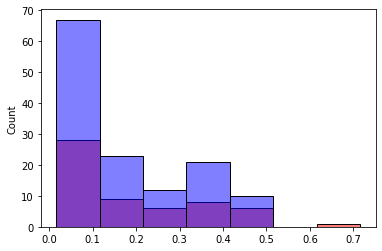

In [38]:
pN = '0.017,0.048,0.016,0.016,0.016,0.435,0.113,0.032,0.403,0.016,0.5,0.645,0.016,0.016,0.032,0.016,0.065,0.081,0.016,0.435,0.048,0.097,0.355,0.016,0.613,0.613,0.017,0.016,0.016,0.032'
pS = '0.177,0.016,0.081,0.145,0.145,0.016,0.968,0.016,0.032,0.016,0.065,0.016,0.016,0.129,0.016,0.081,0.016,0.081,0.016,0.161'

pN = '0.016,0.016,0.371,0.032,0.129,0.016,0.113,0.183,0.354,0.032,0.032,0.339,0.323,0.355,0.367,0.383,0.35,0.31,0.31,0.259,0.233,0.468,0.484,0.484,0.484,0.016,0.048,0.29,0.419,0.435,0.13,0.121,0.016,0.065,0.065,0.065,0.065,0.065,0.016,0.016,0.016,0.016,0.258,0.194,0.016,0.033,0.033,0.097,0.113,0.032,0.097,0.1,0.19,0.19,0.19,0.167,0.016,0.694'
pS = '0.452,0.452,0.452,0.145,0.129,0.113,0.129,0.145,0.145,0.032,0.016,0.016,0.048,0.065,0.097,0.177,0.183,0.2,0.194,0.048,0.333,0.333,0.259,0.21,0.35,0.339,0.339,0.355,0.355,0.35,0.35,0.35,0.069,0.283,0.484,0.484,0.468,0.468,0.032,0.452,0.355,0.355,0.355,0.355,0.355,0.129,0.35,0.323,0.226,0.032,0.032,0.032,0.048,0.048,0.29,0.29,0.403,0.435,0.435,0.107,0.103,0.083,0.083,0.083,0.033,0.065,0.065,0.065,0.065,0.065,0.032,0.032,0.032,0.016,0.016,0.016,0.226,0.306,0.306,0.306,0.048,0.21,0.258,0.258,0.258,0.194,0.161,0.161,0.05,0.033,0.033,0.033,0.097,0.097,0.097,0.339,0.339,0.339,0.016,0.032,0.032,0.032,0.032,0.032,0.032,0.048,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.103,0.1,0.083,0.05,0.034,0.034,0.19,0.19,0.19,0.19,0.167,0.167,0.167,0.15,0.032,0.016,0.016,0.016,0.016'

pN_list = [float(i) for i in pN.split(',')]
pS_list = [float(i) for i in pS.split(',')]

# W = 1 / len(l) * 5
hist_pN, bin_edges_pN = np.histogram(pN_list, bins=5)
hist_pS, bin_edges_pS = np.histogram(pS_list, bins=5)
print(hist_pN)
print(bin_edges_pN)
print(hist_pS)
print(bin_edges_pS)

sns.histplot(pN_list, binwidth=0.1, color='red', alpha=0.5)
sns.histplot(pS_list, binwidth=0.1, color='blue', alpha=0.5)

In [40]:
np.histogram_bin_edges(pS_list, bins=5)

array([0.016 , 0.1096, 0.2032, 0.2968, 0.3904, 0.484 ])

In [95]:
def split_into_bins(l, min_x=0, max_x=0.9, nbin=8):
    
    ## Takes two lists and adjusts bin edges so in either of the lists any bin is empty
    data = np.array(l)
    bins = np.linspace(min_x, max_x, nbin)
    digitized = np.digitize(data, bins)
    bin_counts = [digitized.tolist().count(i) for i in range(1, len(bins))]
    return bin_counts

In [104]:
pN_bins = split_into_bins(pN_list)
pS_bins = split_into_bins(pS_list)

freq_dict = {}
i = 0
for freq in  np.linspace(min_x, max_x, nbin):
    if (pS_bins[i] != 0) and (pN_bins[i] != 0):
        freq_dict[freq] = (pN_bins[i], pS_bins[i])
    i += 1

for freq in freq_dict:
    print('{}\t{}\t{}'.format(round(freq, freq_dict[freq][0], freq_dict[freq][1]))

0.1	29	67
0.23333333333333334	9	25
0.3666666666666667	13	30
0.5	6	11
